In [283]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels.stats.api as sms
import warnings
warnings.filterwarnings('ignore')

In [284]:
DATA_PATH = '/dlabdata1/turkish_wiki'

In [285]:
block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15 19:00', utc = True)]
blocked_days = (block_dates[1] - block_dates[0]).days

In [1047]:
def get_its_fit(df, dependent_variable, first_intervention = pd.to_datetime('2017-04-29', utc = True), 
                second_intervention = pd.to_datetime('2020-01-15', utc = True), save_address = None, verbose=False):      
    
    if 'period' in df.columns:
        df['pre_intervention'] = (df.period == 'pre-block').astype(int)
        df['intervention_1'] = (df.period == 'block').astype(int)
        df['intervention_2'] = (df.period == 'after-block').astype(int)
    else:
        df['pre_intervention'] = (df.index <= first_intervention).astype(int)
        df['intervention_1'] = ((df.index > first_intervention) & (df.index < second_intervention)).astype(int)
        df['intervention_2'] = (df.index >= second_intervention).astype(int)

    df['time'] =  np.zeros(len(df))
    df['time_after_intervention_1'] = np.zeros(len(df))
    df['time_after_intervention_2'] = np.zeros(len(df))

    df.loc[df['pre_intervention'] == 1, 'time'] = np.arange(len(df.loc[df['pre_intervention'] == 1, 'time']))+1
    df.loc[df['intervention_1'] == 1, 'time_after_intervention_1'] = np.arange(len(df.loc[df['intervention_1'] == 1, 'time_after_intervention_1']))+1
    df.loc[df['intervention_2'] == 1, 'time_after_intervention_2'] = np.arange(len(df.loc[df['intervention_2'] == 1, 'time_after_intervention_2']))+1

    Y = df[dependent_variable].values
    X = df[['pre_intervention', 'time', 'intervention_1', 
            'time_after_intervention_1', 'intervention_2',  'time_after_intervention_2']].values
    

    mod = sm.OLS(Y, X)
    res = mod.fit()
    
    if verbose:
        print(res.summary(xname=['pre_intervention', 'time', 'intervention_1', 
                'time_after_intervention_1', 'intervention_2',  'time_after_intervention_2']))
    
    if save_address is not None:
        res.save(save_address)
    
    
    df['fit'] = (res.params * X).sum(axis=1)

    return df, res

In [1048]:
def process_df_for_its(df, stratification_column=None, daily=True):
    
    block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15', utc = True)]
    blocked_days = (block_dates[1] - block_dates[0]).days
    df['date'] = pd.to_datetime(df['date'],   utc = True)
    df = df[df['date'] >= (block_dates[0] - pd.Timedelta(days=blocked_days))]
    df = df.sort_values('date')
    
    if not daily:         
        df = df.set_index('date')
        
    elif stratification_column is None:
        df = df.set_index('date')
        idx = pd.date_range(df.index.min(), df.index.max())
        df = df.reindex(idx, fill_value=0)

    else:
        df = df.set_index(['date', stratification_column])
        idx = pd.date_range(df.index.levels[0].min(), df.index.levels[0].max())

        df = df.reindex(
                pd.MultiIndex.from_product([idx, df.index.levels[1]], 
                                           names=['date', stratification_column]), fill_value=0)

        df = df.reset_index().set_index('date')

    df = df.dropna()
    return df

In [ ]:
d, r = 

In [757]:
def its_with_strata(df, dependent_variable, stratification_column, verbose=False, save_address = None):
    #create unique list of names    
    unique_cats = df[stratification_column].unique()

    #create a data frame dictionary to store your data frames
    df_dict = {elem : pd.DataFrame for elem in unique_cats}
    for key in df_dict.keys():
        df_dict[key] = df[:][df[stratification_column] == key]

    for key in df_dict.keys():
        address = f"{save_address}_{key}"
        stratified_df = df_dict[key]
        if verbose:
            print(key)
        df_dict[key] = get_its_fit(stratified_df, dependent_variable, verbose=verbose, save_address=address)
    return df_dict

In [724]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

# 1) ITS without any stratification
Some of the measures that we establish do not contain any strata for the ITS analysis. These metrics are the Gini coefficient of contributions that measures the centralization of the decision making, average edits per user in time showing the resilience of the remaining active users and metrics related to the birth or death of the users.

In [1059]:
non_statified_its_dict = []

In [1060]:
for data in ['daily_gini.csv', 'weekly_gini.csv', 'monthly_gini.csv', 'daily_avg_edits.csv', 'newcomers.csv']:
    
    name = data.split('.')[0]
    daily = True
    
    if 'gini' in name:
        daily = False
        
    df = pd.read_csv(f'{DATA_PATH}/processed_data/{data}')
    df = process_df_for_its(df, daily=daily)
    dependent_var = list(set(df.columns) - set(['period', 'date']))[0]
    df, df_res = get_its_fit(df, dependent_var, save_address = f'its_results/regression_results/no_stratification/{name}')
    non_statified_its_dict.append({"name": name, "dependent_var" : dependent_var, "data": df, "res": df_res})

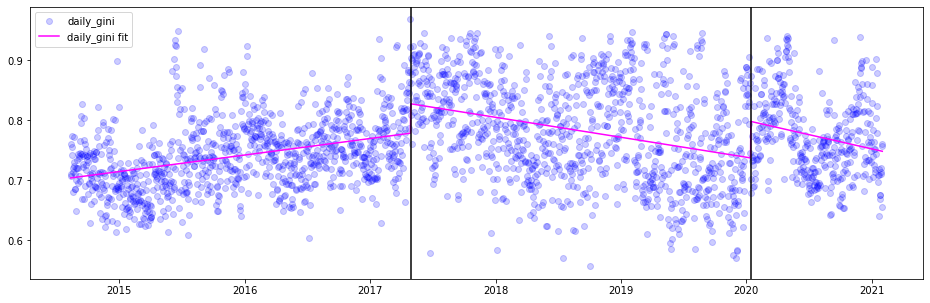

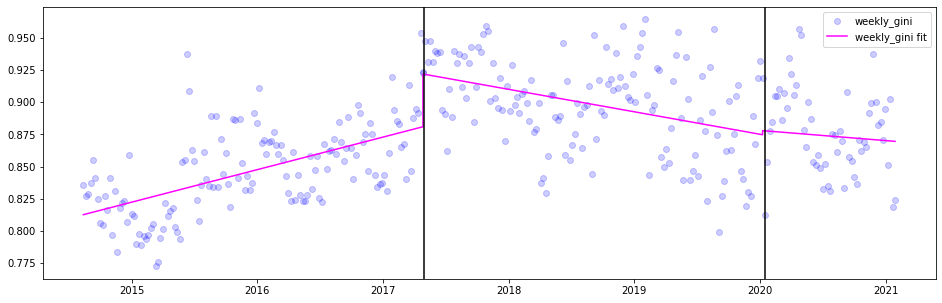

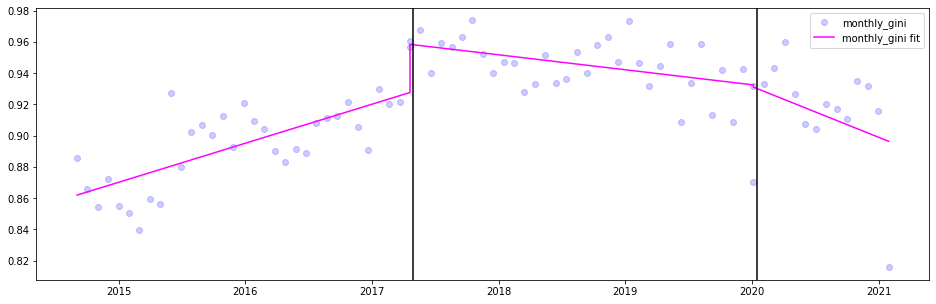

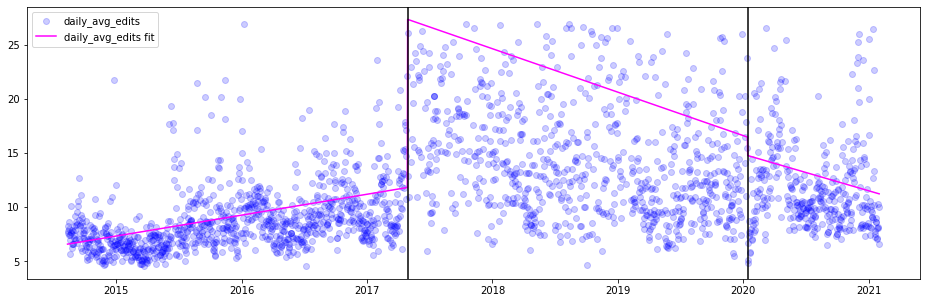

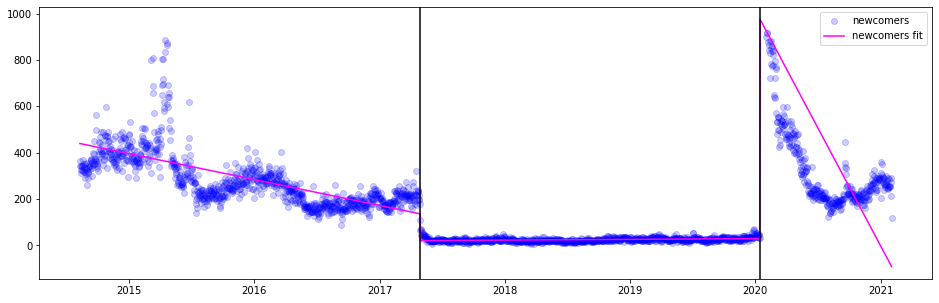

In [1061]:
for elem in non_statified_its_dict:
    df = elem['data']
    dependent_var = elem['dependent_var']
    name = elem['name']
    plt.figure(figsize=(16,5))    
    filtered = df[~is_outlier(df[dependent_var])]
    mask = ~is_outlier(df[dependent_var])
    plt.plot(filtered.index.values, filtered[dependent_var], 'o',label=f"{name}", color='blue', alpha = 0.2)

    plt.plot(df.index.values, df.fit, label=f"{elem['name']} fit", color='magenta')
    plt.legend()
    
    for date in block_dates:
        plt.axvline(date, color='black')
        
    plt.savefig(f'its_results/plots/no_stratification/{name}.png', bbox_inches='tight', dpi = 300)


## 2) ITS with user type stratification.
The data concerning edit activities of users have stratifications about the user type. Editing users can be registered users, anonymous users and bot users. One of the stratified ITS analysis that we can do is considering these user types.

In [1062]:
user_type_stratification_dict = []

In [1063]:
dependent_variable = 'number_of_edits'
for data in ['daily_edits.csv', 'daily_talk_revisions.csv', 'daily_all_talk_revisions.csv', 
             'daily_project_revisions.csv', 'daily_project_talk_revisions.csv', 
             'daily_wikiproject_revisions.csv', 'daily_wikiproject_talk_revisions.csv']:
    print(f'{data}, {dependent_variable}')
    name = data.split('.')[0]
    df = pd.read_csv(f'{DATA_PATH}/processed_data/{data}', index_col=0)
    df = process_df_for_its(df, stratification_column='user_kind')
    results = its_with_strata(df, dependent_variable, 'user_kind', verbose=False, save_address =  f'its_results/regression_results/user_type_stratification/{name}')
    for key in results.keys():
        data, res = results[key]
        user_type_stratification_dict.append({"name": name, "dependent_var" : dependent_variable,
                                              "stratification": 'user_type', "strata" : key,
                                              "data": data, "res": res})


daily_edits.csv, number_of_edits
daily_talk_revisions.csv, number_of_edits
daily_all_talk_revisions.csv, number_of_edits
daily_project_revisions.csv, number_of_edits
daily_project_talk_revisions.csv, number_of_edits
daily_wikiproject_revisions.csv, number_of_edits
daily_wikiproject_talk_revisions.csv, number_of_edits


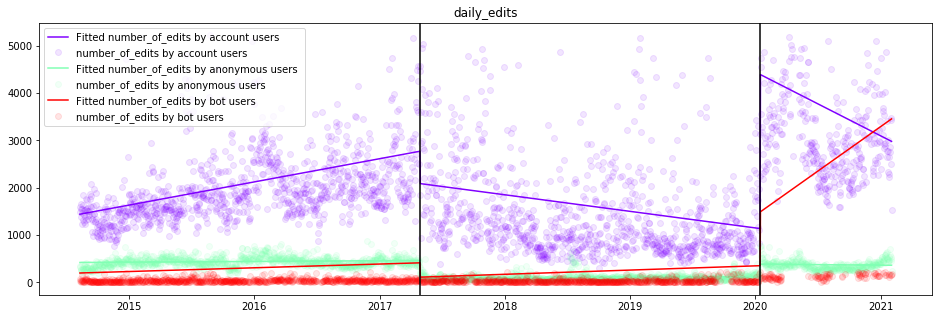

In [777]:
elem = user_type_stratification_dict[0]
dependent_var = elem['dependent_var']
data_dict = elem['data_dict']
name = elem['name']
plt.figure(figsize=(16,5))
color=cm.rainbow(np.linspace(0,1,len(data_dict)))
plt.title(name)
for i, key in enumerate(data_dict.keys()):
    plt.plot(data_dict[key][0].index.values, data_dict[key][0].fit, label=f'Fitted {dependent_var} by {key} users ', color=color[i])
    filtered = data_dict[key][0][~is_outlier(data_dict[key][0][dependent_var])]
    mask = ~is_outlier(data_dict[key][0][dependent_var])
    plt.plot(filtered.index.values, filtered[dependent_var], 'o', label=f'{dependent_var} by {key} users', color=color[i], alpha = 0.1)
    plt.legend()
for date in block_dates:
    plt.axvline(date, color='black')
    
plt.savefig(f'its_results/plots/user_type_stratification/{name}.png', bbox_inches='tight', dpi = 300)


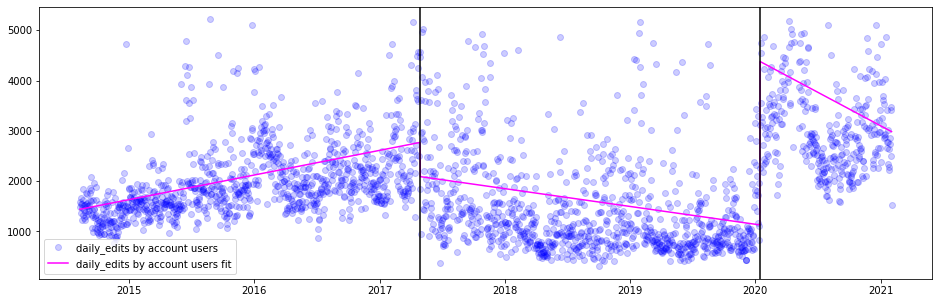

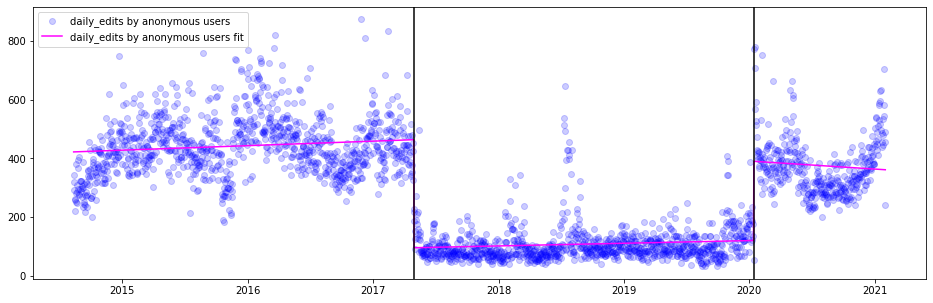

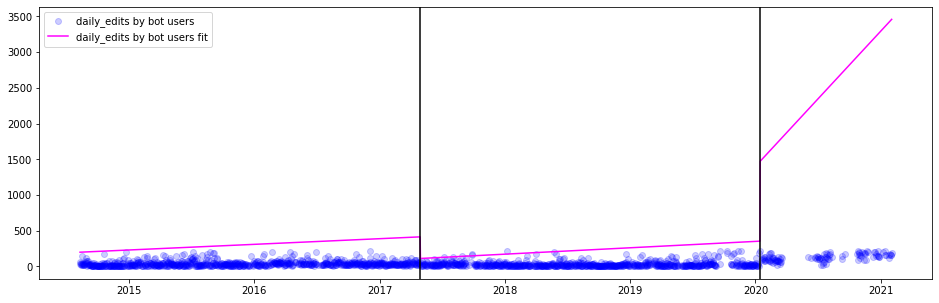

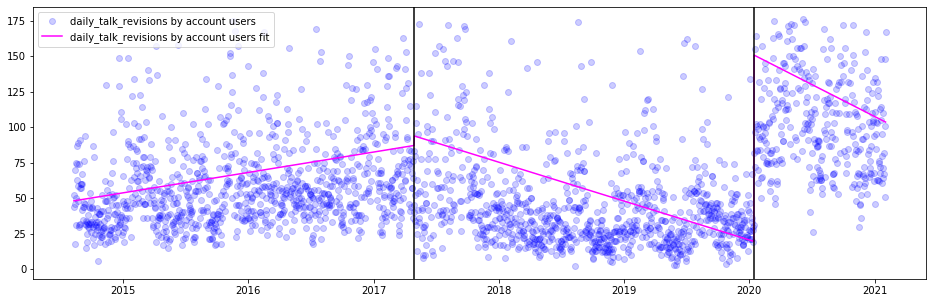

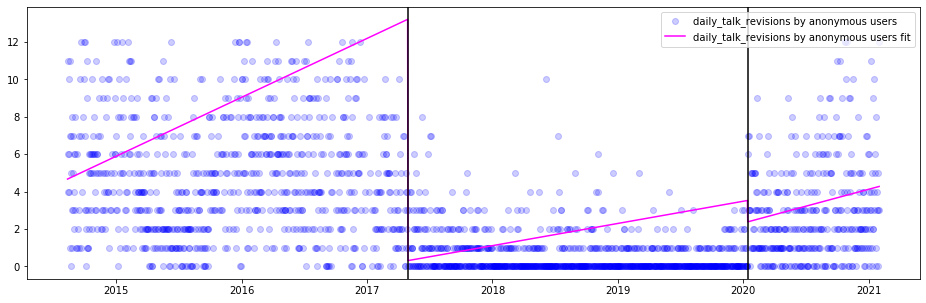

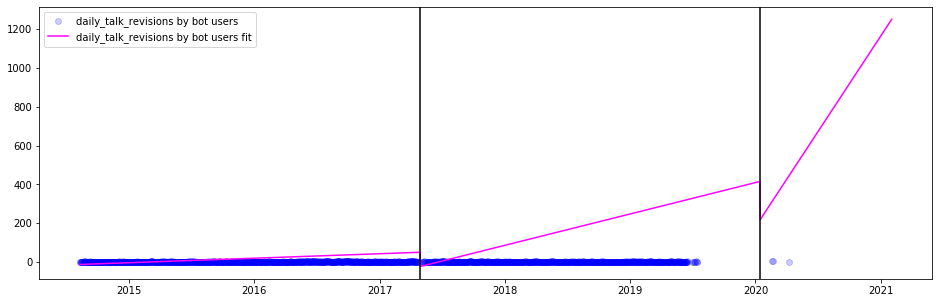

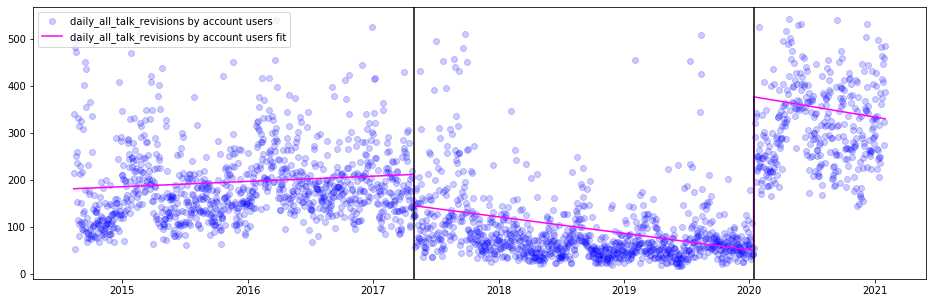

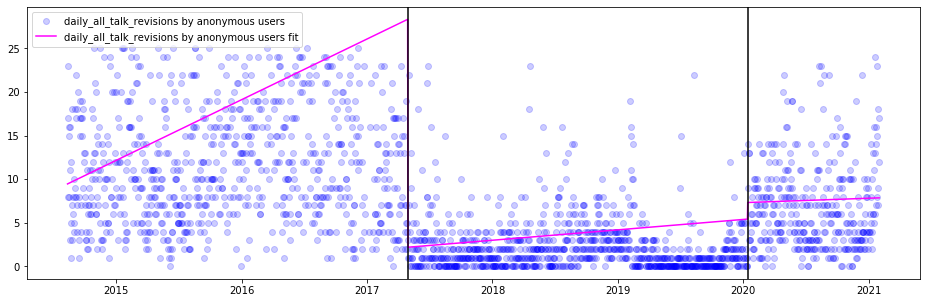

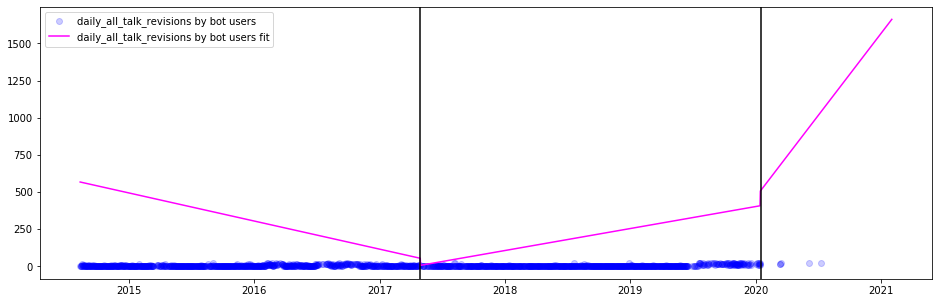

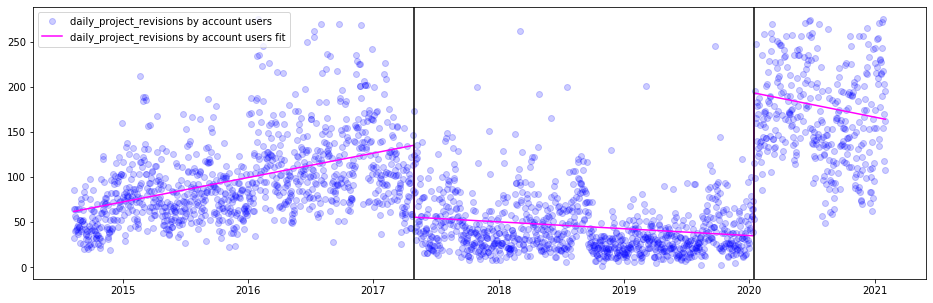

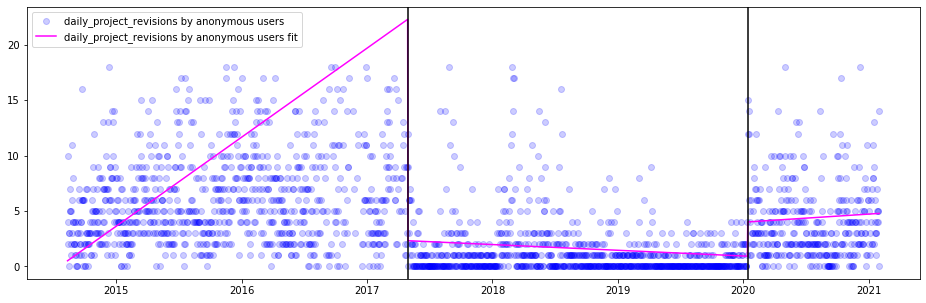

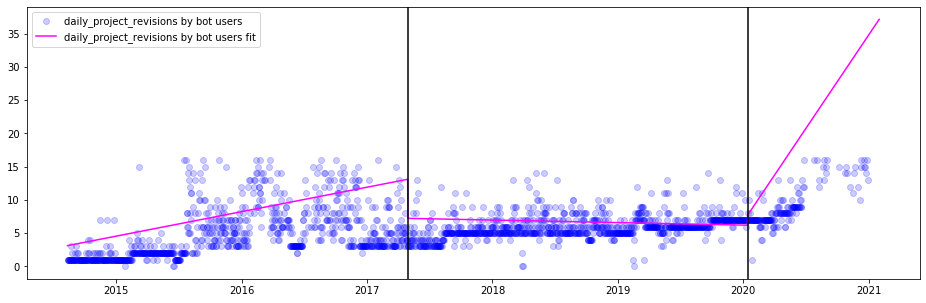

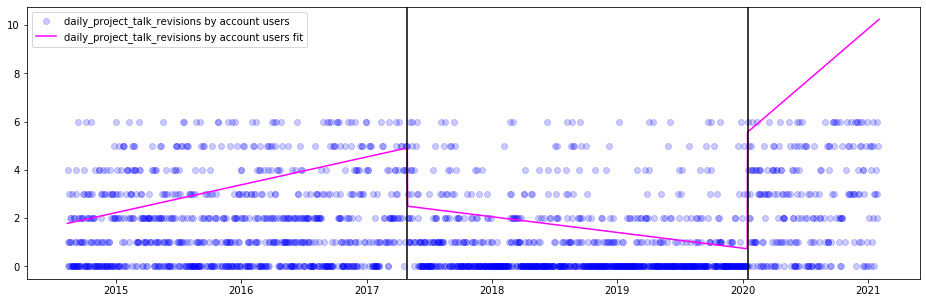

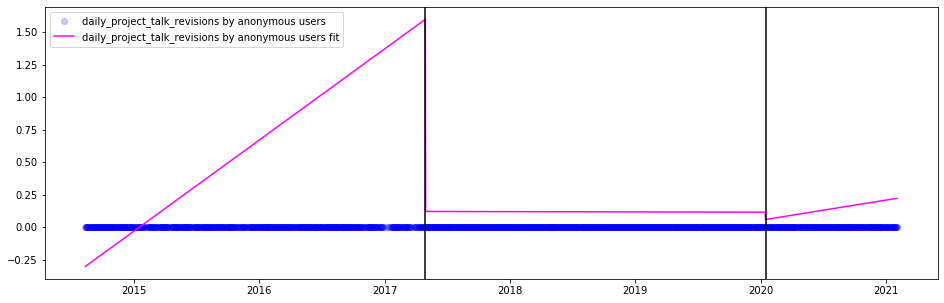

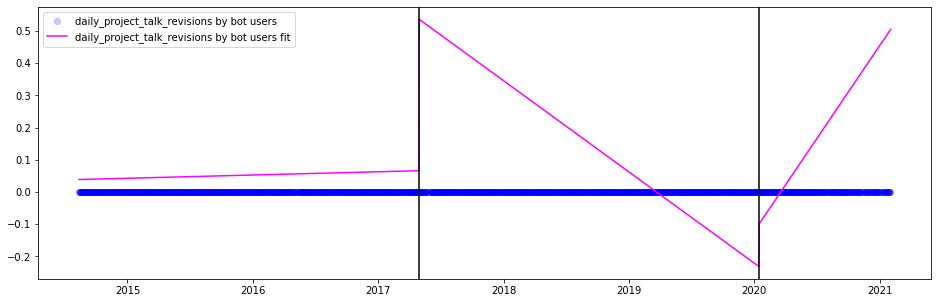

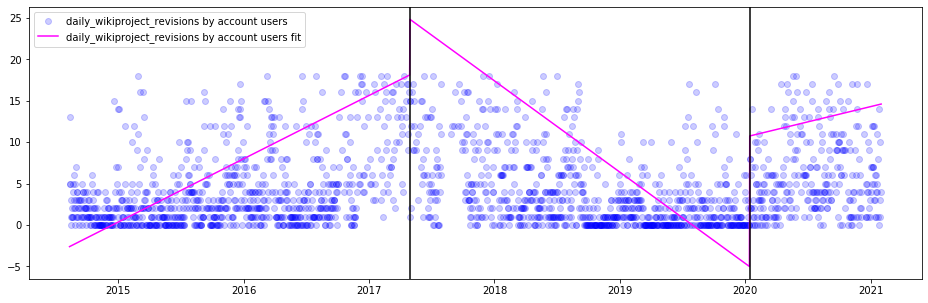

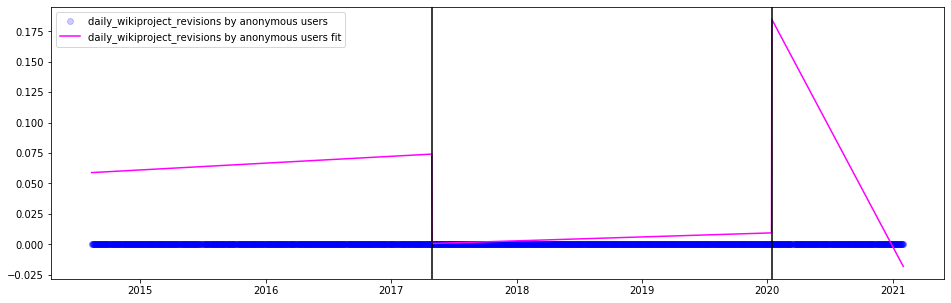

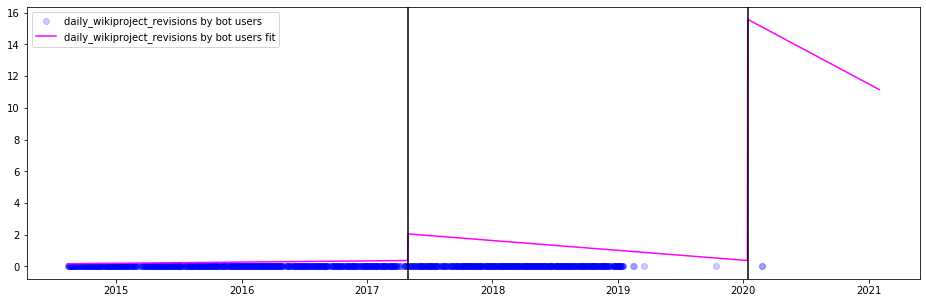

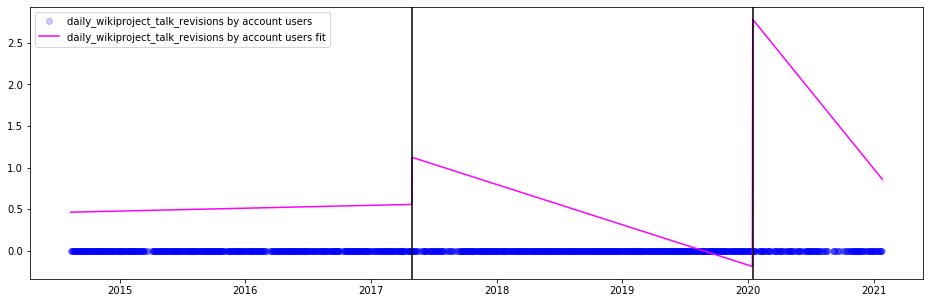

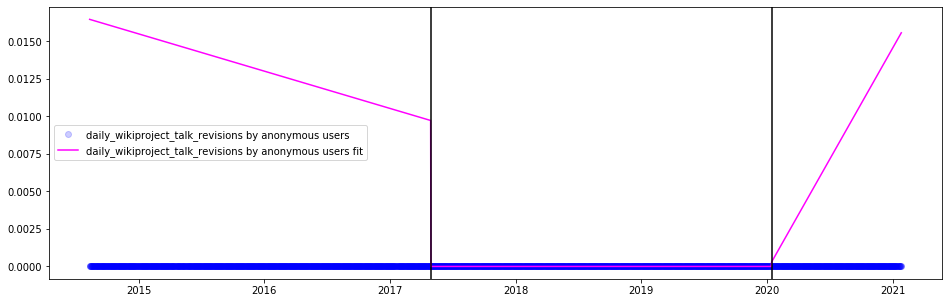

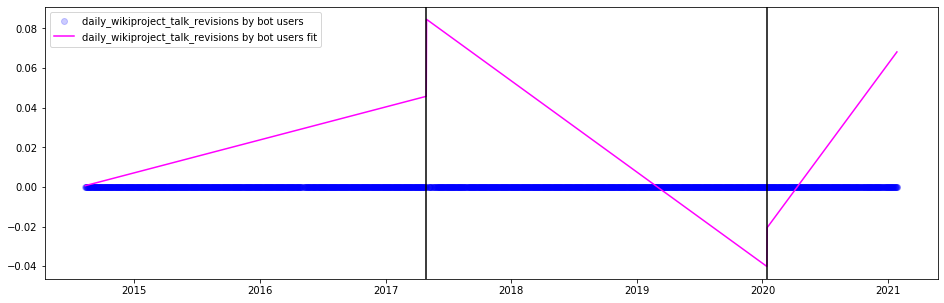

In [1149]:
for elem in user_type_stratification_dict:
    df = elem['data']
    dependent_var = elem['dependent_var']
    name = elem['name']
    plt.figure(figsize=(16,5))    
    filtered = df[~is_outlier(df[dependent_var])]
    mask = ~is_outlier(df[dependent_var])
    plt.plot(filtered.index.values, filtered[dependent_var], 'o',label=f"{name} by {elem['strata']} users", color='blue', alpha = 0.2)

    plt.plot(df.index.values, df.fit, label=f"{elem['name']} by {elem['strata']} users fit", color='magenta')
    plt.legend()
    
    for date in block_dates:
        plt.axvline(date, color='black')
        
#     plt.savefig(f'its_results/plots/no_stratification/{name}.png', bbox_inches='tight', dpi = 300)


Analysis shows that user type stratification is only relevant in the case of daily edits. Talk pages and pages related to Projects or WikiProject receive too few edits from bots or anonymous users and the fit is quite poor. Futhermore, Project Talk pages and WikiProject pages are too variable even for registered users and shouldn't be further considered in these analysis.

## 3) ITS with topic stratification.
As we have observed in the previous analysis, the main signals to consider for the ITS that are significant and interesting are the number of edits, revert rates and the gini coefficient of contributions.
Using WikiPDA we can obtain the topic probabilities for any given article. The analysis for these main signals can be conducted separately for each topic that we get with WikiPDA to observe how the ban impacted the contributions to wikipedia based on different article topics

In [1064]:
topic_stratification_dict = []

In [1065]:
stratification_variable = 'topic'
for data in ['daily_edits_by_topic.csv', 'revert_rate_by_topic.csv', 'daily_topic_gini.csv', 
             'weekly_topic_gini.csv', 'monthly_topic_gini.csv']:
    name = data.split('.')[0]
    df = pd.read_csv(f'{DATA_PATH}/processed_data/{data}')
    dependent_variable = list(set(df.columns) - set(['topic', 'date', 'period']))[0]
    print(f'{data}, {dependent_variable}')
    
    if 'gini' in name:
        daily = False
        
    df = process_df_for_its(df, stratification_column= 'topic', daily=daily)
    results = its_with_strata(df, dependent_variable, stratification_variable, verbose=True, save_address =  f'its_results/regression_results/page_category_stratification/{name}')

    for key in results.keys():
        data, res = results[key]
        topic_stratification_dict.append({"name": name, "dependent_var" : dependent_variable,
                                              "stratification": 'topic', "strata" : key,
                                              "data": data, "res": res})

daily_edits_by_topic.csv, number_of_edits
Africa_
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     51.67
Date:                Sat, 05 Jun 2021   Prob (F-statistic):           5.58e-51
Time:                        13:06:46   Log-Likelihood:                -14760.
No. Observations:                2366   AIC:                         2.953e+04
Df Residuals:                    2360   BIC:                         2.957e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

### Aggregate Results

In [1066]:
its_results = pd.DataFrame(columns = ['metric', 'dependent_variable', 'stratification', 'strata', 'pre_intervention', 'time', 'intervention_1', 
                    'time_after_intervention_1', 'intervention_2',  'time_after_intervention_2', 'P_pre_intervention', 'P_time', 'P_intervention_1', 
                    'P_time_after_intervention_1', 'P_intervention_2',  'P_time_after_intervention_2', 'fit_before_intervention_1', 'fit_before_intervention_2', 'fit_end', 'F_squared'])

In [1067]:
df_row = its_results.shape[0]
for idx, elem in enumerate(non_statified_its_dict):
    index = df_row + idx
    d = elem['data']

    element = [elem['name']] + [elem['dependent_var']] + [None]*2 + \
               elem['res'].params.tolist() + elem['res'].pvalues.tolist() + [d.loc[d['pre_intervention'] == 1].iloc[-1, :].fit] + \
               [d.loc[d['intervention_1'] == 1].iloc[-1, :].fit] + [d.loc[d['intervention_2'] == 1].iloc[-1, :].fit] + [elem['res'].rsquared]
    
    its_results.loc[index, :] = element
        

In [1068]:
df_row = its_results.shape[0]
for idx, elem in enumerate(user_type_stratification_dict):
    index = df_row + idx

    d = elem['data']

    element = [elem['name']] + [elem['dependent_var']] + [elem['stratification']] + [elem['strata']] + \
               elem['res'].params.tolist() + elem['res'].pvalues.tolist() + [d.loc[d['pre_intervention'] == 1].iloc[-1, :].fit] + \
               [d.loc[d['intervention_1'] == 1].iloc[-1, :].fit] + [d.loc[d['intervention_2'] == 1].iloc[-1, :].fit] + [elem['res'].rsquared]
    
    its_results.loc[index, :] = element
        

In [1069]:
df_row = its_results.shape[0]
for idx, elem in enumerate(topic_stratification_dict):
    index = df_row + idx

    d = elem['data']

    element = [elem['name']] + [elem['dependent_var']] + [elem['stratification']] + [elem['strata']] + \
               elem['res'].params.tolist() + elem['res'].pvalues.tolist() + [d.loc[d['pre_intervention'] == 1].iloc[-1, :].fit] + \
               [d.loc[d['intervention_1'] == 1].iloc[-1, :].fit] + [d.loc[d['intervention_2'] == 1].iloc[-1, :].fit] + [elem['res'].rsquared]
    
    its_results.loc[index, :] = element
        

In [1089]:
pcols = [ 
       'P_intervention_1',  'P_intervention_2']

In [1071]:
non_statified_its_dict[-1]['data'].iloc[-388:-378]

,number_of_newcomers,pre_intervention,intervention_1,intervention_2,time,time_after_intervention_1,time_after_intervention_2,fit
2020-01-11 00:00:00+00:00,44,0,1,0,0.0,987.0,0.0,29.065783
2020-01-12 00:00:00+00:00,48,0,1,0,0.0,988.0,0.0,29.074362
2020-01-13 00:00:00+00:00,33,0,1,0,0.0,989.0,0.0,29.082940
2020-01-14 00:00:00+00:00,31,0,1,0,0.0,990.0,0.0,29.091519
2020-01-15 00:00:00+00:00,9230,0,0,1,0.0,0.0,1.0,975.056169
2020-01-16 00:00:00+00:00,15531,0,0,1,0.0,0.0,2.0,972.272912
2020-01-17 00:00:00+00:00,4504,0,0,1,0.0,0.0,3.0,969.489655
2020-01-18 00:00:00+00:00,2485,0,0,1,0.0,0.0,4.0,966.706399
2020-01-19 00:00:00+00:00,2021,0,0,1,0.0,0.0,5.0,963.923142
2020-01-20 00:00:00+00:00,1578,0,0,1,0.0,0.0,6.0,961.139885


In [1131]:
its_results[(its_results[pcols] <= 0.05).all(axis=1)]

,metric,dependent_variable,stratification,strata,pre_intervention,time,intervention_1,time_after_intervention_1,intervention_2,time_after_intervention_2,...,P_intervention_1,P_time_after_intervention_1,P_intervention_2,P_time_after_intervention_2,fit_before_intervention_1,fit_before_intervention_2,fit_end,F_squared,intervention_1_level_change,intervention_2_level_change
0,daily_gini,gini,NaN,NaN,0.703972,7.53386e-05,0.827728,-9.10711e-05,0.798344,-0.000129736,...,0,4.94307e-32,0,4.11946e-05,0.778633,0.737476,0.748526,0.158793,6.30526,8.25353
1,weekly_gini,gini,NaN,NaN,0.812119,0.000484574,0.922247,-0.000334631,0.878071,-0.000151697,...,0,7.62746e-07,6.1289e-251,0.571903,0.880929,0.874729,0.869576,0.436298,4.69029,0.381957
2,monthly_gini,gini,NaN,NaN,0.85985,0.00205197,0.959166,-0.000786758,0.933678,-0.00266775,...,1.20271e-90,0.0325532,2.20866e-74,0.055258,0.927565,0.932417,0.89633,0.651069,3.40691,0.135298
3,daily_avg_edits,avg_number_of_edits_per_active_user,NaN,NaN,6.58865,0.00527132,27.3327,-0.0109618,14.7716,-0.00921812,...,3.7653e-199,3.25325e-14,2.82403e-28,0.12159,11.8125,16.4696,11.2318,0.192944,131.388,-10.3101
5,daily_edits,number_of_edits,user_type,account,1439.88,1.34121,2091.63,-0.970451,4382.61,-3.63867,...,1.87824e-100,3.49e-09,1.55931e-159,8.62283e-08,2770.36,1130.88,2985.36,0.224065,-24.4998,287.538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,monthly_topic_gini,gini,topic,Europe_,0.857428,-3.42072e-05,0.947087,-0.00210555,0.894272,-0.0005354,...,2.11162e-65,0.00861106,2.31137e-47,0.871904,0.856265,0.875498,0.887312,0.298463,10.6068,2.14435
342,monthly_topic_gini,gini,topic,Entertainment,0.751754,0.00299085,0.860336,-0.000371268,0.843123,-0.00175334,...,1.18139e-63,0.621495,8.00275e-47,0.582477,0.853443,0.847712,0.820329,0.344672,0.807651,-0.541411
343,monthly_topic_gini,gini,topic,Engineering,0.723458,0.00361672,0.906477,-0.00422673,0.882324,-0.00945341,...,1.46429e-56,5.41485e-05,6.88842e-40,0.0268169,0.846426,0.762768,0.75943,0.391096,7.09456,15.674
344,monthly_topic_gini,gini,topic,Education,0.699255,0.0017423,0.820784,-0.0016333,0.745978,0.00159598,...,1.52948e-55,0.0809354,6.0981e-37,0.684669,0.758493,0.765252,0.766726,0.290375,8.2125,-2.51865


In [1090]:
its_results[(its_results[pcols] >= 0.05).sum(axis=1)>1]

,metric,dependent_variable,stratification,strata,pre_intervention,time,intervention_1,time_after_intervention_1,intervention_2,time_after_intervention_2,P_pre_intervention,P_time,P_intervention_1,P_time_after_intervention_1,P_intervention_2,P_time_after_intervention_2,fit_before_intervention_1,fit_before_intervention_2,fit_end,F_squared
9,daily_talk_revisions,number_of_edits,user_type,anonymous,4.66451,0.0086184,0.30878,0.00325007,2.37905,0.00494378,0.00380172,0.00217952,0.848085,0.248835,0.358603,0.671713,13.214,3.52635,4.27746,0.0212451
18,daily_project_talk_revisions,number_of_edits,user_type,anonymous,-0.30352,0.00191804,0.121071,-5.8312e-06,0.0587875,0.00042513,0.0244414,5.98091e-16,0.36945,0.980272,0.786308,0.663197,1.59726,0.115298,0.222037,0.0413212
24,daily_wikiproject_talk_revisions,number_of_edits,user_type,anonymous,0.016483,-6.804e-06,-3.11399e-19,6.28454e-22,0.000252621,4.05482e-05,0.0170639,0.572291,1,1,0.982007,0.428637,0.00973346,3.10771e-19,0.0155798,0.00347288


In [1096]:
its_results = its_results.set_index(['metric','dependent_variable','stratification','strata'])

In [1102]:
its_results['intervention_1_level_change'] = 100*(its_results['intervention_1']-its_results['fit_before_intervention_1'])/its_results['fit_before_intervention_1']
its_results['intervention_2_level_change'] = 100*(its_results['intervention_2']-its_results['fit_before_intervention_2'])/its_results['fit_before_intervention_2']


In [1116]:
its_results.reset_index(inplace=True)

In [1123]:
its_results[(its_results.metric == 'daily_edits_by_topic')].sort_values('intervention_1_level_change')

,metric,dependent_variable,stratification,strata,pre_intervention,time,intervention_1,time_after_intervention_1,intervention_2,time_after_intervention_2,...,P_intervention_1,P_time_after_intervention_1,P_intervention_2,P_time_after_intervention_2,fit_before_intervention_1,fit_before_intervention_2,fit_end,F_squared,intervention_1_level_change,intervention_2_level_change
82,daily_edits_by_topic,number_of_edits,topic,Television,165.021,0.174449,122.841,0.041167,348.569,-0.235571,...,3.72932e-11,0.202793,6.28547e-31,0.0783531,338.075,163.596,258.109,0.0581077,-63.6645,113.066
48,daily_edits_by_topic,number_of_edits,topic,Films,89.0167,0.18528,102.771,0.0187858,310.837,-0.350641,...,5.74447e-08,0.569253,4.045e-24,0.01033,272.814,121.369,176.191,0.040476,-62.3291,156.108
37,daily_edits_by_topic,number_of_edits,topic,Comics and Anime,32.3237,0.0601202,35.4276,-0.00382494,86.2871,-0.0101627,...,4.84189e-23,0.53736,1.86828e-49,0.692175,91.963,31.6409,82.3846,0.133462,-61.4763,172.707
57,daily_edits_by_topic,number_of_edits,topic,Media_,307.43,0.331009,258.339,0.0475165,818.84,-0.705931,...,5.68369e-18,0.359649,2.32642e-62,0.00102314,635.791,305.381,547.762,0.103789,-59.3673,168.137
60,daily_edits_by_topic,number_of_edits,topic,Music,123.334,0.117036,97.3779,0.0290859,360.458,-0.373145,...,7.04016e-16,0.165123,5.7524e-73,1.75327e-05,239.434,126.173,217.17,0.113562,-59.3299,185.686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,daily_edits_by_topic,number_of_edits,topic,Europe_,396.411,0.16896,530.357,-0.164032,882.288,-0.47693,...,1.44305e-71,0.0010699,3.63074e-76,0.0214984,564.019,367.965,699.147,0.0774818,-5.96832,139.775
44,daily_edits_by_topic,number_of_edits,topic,Engineering,90.1034,0.0834967,163.932,-0.144215,418.18,-0.834227,...,6.23447e-74,5.71647e-21,6.22366e-167,1.00254e-38,172.932,21.1595,97.8366,0.229014,-5.20428,1876.32
64,daily_edits_by_topic,number_of_edits,topic,Northern Europe,95.5899,0.0552126,152.941,-0.0572294,231.612,-0.138788,...,3.36381e-57,0.000463291,2.97478e-51,0.0400891,150.361,96.2839,178.318,0.0507956,1.71595,140.552
38,daily_edits_by_topic,number_of_edits,topic,Computing,207.279,0.15831,376.152,-0.39299,969.505,-1.90705,...,7.89135e-60,3.201e-23,2.25251e-139,4.54285e-31,364.323,-12.9083,237.199,0.216291,3.24691,-7610.73


In [1132]:
p_cols = ['P_pre_intervention', 'P_time', 'P_intervention_1', 
          'P_time_after_intervention_1', 'P_intervention_2', 'P_time_after_intervention_2']

In [1143]:
its_results[(its_results.metric == 'daily_edits_by_topic')].sort_values('intervention_2_level_change').head(50)

,metric,dependent_variable,stratification,strata,pre_intervention,time,intervention_1,time_after_intervention_1,intervention_2,time_after_intervention_2,...,P_intervention_1,P_time_after_intervention_1,P_intervention_2,P_time_after_intervention_2,fit_before_intervention_1,fit_before_intervention_2,fit_end,F_squared,intervention_1_level_change,intervention_2_level_change
38,daily_edits_by_topic,number_of_edits,topic,Computing,207.279,0.15831,376.152,-0.39299,969.505,-1.90705,...,7.89135e-60,3.201e-23,2.25251e-139,4.54285e-31,364.323,-12.9083,237.199,0.216291,3.24691,-7610.73
61,daily_edits_by_topic,number_of_edits,topic,North America,55.3082,0.218662,141.784,0.0402605,247.342,0.204958,...,1.48112e-08,0.356013,8.12607e-10,0.256366,272.221,181.642,326.046,0.0246345,-47.9158,36.1702
27,daily_edits_by_topic,number_of_edits,topic,Architecture,36.3898,0.0892525,101.305,0.0140286,157.542,0.245018,...,1.22295e-14,0.538652,8.33423e-14,0.00953044,124.928,115.194,251.629,0.0500538,-18.9092,36.763
50,daily_edits_by_topic,number_of_edits,topic,Geographical,65.9293,0.0763085,111.968,0.0119262,186.453,0.277573,...,1.24812e-15,0.623635,1.20687e-16,0.00583778,141.627,123.775,293.041,0.0529734,-20.9416,50.638
85,daily_edits_by_topic,number_of_edits,topic,Visual arts_,63.1398,0.138979,139.097,-0.00943737,239.935,0.167966,...,1.45064e-28,0.662884,1.62563e-32,0.0609827,201.007,129.754,304.434,0.0814498,-30.7999,84.9145
65,daily_edits_by_topic,number_of_edits,topic,Oceania,39.8556,0.0383596,52.8287,-0.0023309,104.36,-0.01908,...,3.0302e-42,0.725876,1.02073e-61,0.488129,77.9084,50.5211,97.0337,0.0877119,-32.1913,106.568
82,daily_edits_by_topic,number_of_edits,topic,Television,165.021,0.174449,122.841,0.041167,348.569,-0.235571,...,3.72932e-11,0.202793,6.28547e-31,0.0783531,338.075,163.596,258.109,0.0581077,-63.6645,113.066
33,daily_edits_by_topic,number_of_edits,topic,Central Africa,27.3121,0.0167307,32.8766,-0.011018,47.4252,0.00378431,...,1.55825e-50,0.00336321,2.17808e-41,0.807596,43.909,21.9688,48.8783,0.0544996,-25.1257,115.875
41,daily_edits_by_topic,number_of_edits,topic,Eastern Africa,36.5029,0.0155364,43.3328,-0.0158241,61.1755,-0.0128162,...,6.67624e-50,0.00150833,2.81281e-39,0.534302,51.915,27.6669,56.254,0.0391019,-16.5313,121.114
77,daily_edits_by_topic,number_of_edits,topic,Southern Africa,29.9749,0.0320203,29.479,0.0019994,72.3879,0.00315287,...,7.6213e-36,0.622003,5.2144e-78,0.851026,61.739,31.4584,73.5986,0.158561,-52.2523,130.107


In [1163]:
with open(f'{DATA_PATH}/goodfaith.json') as json_file:
    data = json.load(json_file)

In [1164]:
len(data)

4990847

In [1165]:
data[-1]

{'rev_id': '24672716',
 'goodfaith': {'false': 0.37497283206091714, 'true': 0.6250271679390829}}

In [1161]:
data[-2]

{'rev_id': '24672695',
 'goodfaith': {'false': 0.05773168463382783, 'true': 0.9422683153661722}}

In [1167]:
del data